In [42]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
from statsmodels.formula.api import ols #more advanced than scikit-learn
from statsmodels.formula.api import ols as sm_ols

from statsmodels.tsa.stattools import adfuller #?
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score #haven't implemented the r2_score yet
from sklearn.linear_model import LinearRegression #haven't implemented yet
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split #haven't implemented yet
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from math import sqrt
import seaborn as sns
import pandas_datareader.data as reader
import math
import matplotlib.pyplot as plt

import pandas_datareader as pdr 
from statsmodels.tsa.stattools import adfuller

import sys


In [4]:
returns = pd.read_csv('returns.csv')
returns['date'] = pd.to_datetime(returns['date'], format='%Y%m%d', errors='coerce') #change dates format
returns['RET'] = returns['RET'].apply(pd.to_numeric, errors='coerce') #had to change the ret to numeric values 
returns = returns.drop(['PRC','PERMNO'],axis=1)
returns = returns.rename(columns={'date':'Date'})
returns

,Date,NCUSIP,TICKER,RET,ewretd,sprtrn
0,2000-01-03,13810830,CITI,-0.067797,0.002878,-0.009549
1,2000-01-04,13810830,CITI,-0.072727,-0.017465,-0.038345
2,2000-01-05,13810830,CITI,0.078431,0.007821,0.001922
3,2000-01-06,13810830,CITI,-0.018182,0.004504,0.000956
4,2000-01-07,13810830,CITI,-0.055556,0.017008,0.027090
...,...,...,...,...,...,...
15928,2020-12-24,02079K30,GOOGL,0.003431,-0.000277,0.003537
15929,2020-12-28,02079K30,GOOGL,0.022951,0.001350,0.008723
15930,2020-12-29,02079K30,GOOGL,-0.009132,-0.008483,-0.002227
15931,2020-12-30,02079K30,GOOGL,-0.012237,0.010155,0.001342


In [6]:
ff = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3_daily',start=2000,end=2021)[0] # the [0] is because the imported obect is a dictionary, and key=0 is the dataframe
ff = ff.reset_index().rename(columns={"Mkt-RF":"mkt_excess"}) 
ff[['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] = ff[['mkt_excess', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] / 100 #convert to decimal format 
ff['year'] = ff['Date'].dt.year
ff['month'] = ff['Date'].dt.month

ff

,Date,mkt_excess,SMB,HML,RMW,CMA,RF,year,month
0,2000-01-03,-0.0071,-0.0009,-0.0140,-0.0146,-0.0077,0.00021,2000,1
1,2000-01-04,-0.0406,0.0035,0.0206,0.0043,0.0146,0.00021,2000,1
2,2000-01-05,-0.0009,0.0031,0.0019,0.0042,0.0101,0.00021,2000,1
3,2000-01-06,-0.0073,-0.0003,0.0127,0.0065,0.0119,0.00021,2000,1
4,2000-01-07,0.0321,-0.0095,-0.0142,-0.0087,-0.0095,0.00021,2000,1
...,...,...,...,...,...,...,...,...,...
5279,2020-12-24,0.0021,-0.0043,-0.0017,0.0024,-0.0005,0.00000,2020,12
5280,2020-12-28,0.0046,-0.0065,0.0032,0.0146,0.0050,0.00000,2020,12
5281,2020-12-29,-0.0040,-0.0142,0.0024,0.0075,-0.0028,0.00000,2020,12
5282,2020-12-30,0.0027,0.0103,0.0004,-0.0067,-0.0006,0.00000,2020,12


In [7]:
Returns = pd.merge(returns, ff, on='Date',how='inner')
Returns

#filter dataset to 4 stocks we are observing (COULDNT FIND CITI)

Returns = Returns[(Returns['TICKER'] == 'AAPL') | 
                  (Returns['TICKER'] == 'COKE') |
                  (Returns['TICKER'] == 'GOOGL')]

#get in logrithmic returns to account for continuous compounding (didn't apply it to risk free rate)
Returns[['RET','ewretd','sprtrn','mkt_excess','SMB','HML','RMW','CMA','RF']] = np.log(1 + Returns[['RET','ewretd','sprtrn','mkt_excess','SMB','HML','RMW','CMA','RF']])
Returns[['RET','ewretd','sprtrn','mkt_excess','SMB','HML','RMW','CMA','RF']] = 1 + Returns[['RET','ewretd','sprtrn','mkt_excess','SMB','HML','RMW','CMA','RF']]
Returns

,Date,NCUSIP,TICKER,RET,ewretd,sprtrn,mkt_excess,SMB,HML,RMW,CMA,RF,year,month
1,2000-01-03,19109810,COKE,1.020888,1.002874,0.990405,0.992875,0.999100,0.985901,0.985292,0.992270,1.00021,2000,1
2,2000-01-03,03783310,AAPL,1.085034,1.002874,0.990405,0.992875,0.999100,0.985901,0.985292,0.992270,1.00021,2000,1
4,2000-01-04,19109810,COKE,1.019828,0.982381,0.960900,0.958553,1.003494,1.020391,1.004291,1.014494,1.00021,2000,1
5,2000-01-04,03783310,AAPL,0.911923,0.982381,0.960900,0.958553,1.003494,1.020391,1.004291,1.014494,1.00021,2000,1
7,2000-01-05,19109810,COKE,1.033015,1.007791,1.001920,0.999100,1.003095,1.001898,1.004191,1.010049,1.00021,2000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15928,2020-12-30,03783310,AAPL,0.991436,1.010104,1.001341,1.002696,1.010247,1.000400,0.993277,0.999400,1.00000,2020,12
15929,2020-12-30,02079K30,GOOGL,0.987688,1.010104,1.001341,1.002696,1.010247,1.000400,0.993277,0.999400,1.00000,2020,12
15930,2020-12-31,19109810,COKE,0.999137,0.998941,1.006418,1.003892,0.993076,1.004490,1.005584,0.997998,1.00000,2020,12
15931,2020-12-31,03783310,AAPL,0.992267,0.998941,1.006418,1.003892,0.993076,1.004490,1.005584,0.997998,1.00000,2020,12


In [8]:
Returns_monthly = (Returns.groupby('TICKER').resample('M', on='Date').prod() -1).reset_index()
Returns_monthly['year'], Returns_monthly['month'] = Returns_monthly['Date'].dt.year, Returns_monthly['Date'].dt.month
Returns_monthly['RET'] = Returns_monthly['RET'] - Returns_monthly['RF']
Returns_monthly

,TICKER,Date,RET,ewretd,sprtrn,mkt_excess,SMB,HML,RMW,CMA,RF,year,month
0,AAPL,2000-01-31,-0.026512,0.054863,-0.053425,-0.049817,0.042313,-0.022284,-0.062559,0.046051,0.004208,2000,1
1,AAPL,2000-02-29,0.088513,0.110299,-0.021612,0.023900,0.175060,-0.077177,-0.156429,-0.013442,0.004409,2000,2
2,AAPL,2000-03-31,0.146552,0.010345,0.093186,0.045368,-0.141438,0.074089,0.113542,-0.015726,0.004610,2000,3
3,AAPL,2000-04-30,-0.111473,-0.081621,-0.034751,-0.069142,-0.055609,0.074341,0.067247,0.053853,0.004569,2000,4
4,AAPL,2000-05-31,-0.339764,-0.050879,-0.024436,-0.046803,-0.044118,0.047078,0.039743,0.006877,0.005072,2000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,GOOGL,2020-08-31,0.093503,0.040180,0.069674,0.076088,-0.009448,-0.029964,0.040520,-0.013719,0.000000,2020,8
581,GOOGL,2020-09-30,-0.105532,-0.025043,-0.041636,-0.038699,0.000152,-0.030188,-0.012516,-0.018802,0.000000,2020,9
582,GOOGL,2020-10-31,0.096226,0.003063,-0.029482,-0.022722,0.046907,0.039253,-0.005573,-0.005520,0.000000,2020,10
583,GOOGL,2020-11-30,0.082548,0.170860,0.106194,0.124006,0.058971,0.013968,-0.023112,0.007975,0.000000,2020,11


In [9]:
def reg_in_groupby(df,formula="RET ~ mkt_excess + SMB + HML + RMW + CMA"):
    return pd.Series(sm.formula.ols(formula,data = df).fit().params)

# def r2(df,formula="RET ~ mkt_excess + SMB + HML + RMW + CMA"):
#     return pd.Series(sm.formula.ols(formula,data = df).fit().rsquared)

# def pred(df,formula="RET ~ mkt_excess + SMB + HML + RMW + CMA"):
#     return pd.Series(sm.formula.ols(formula,data = df).fit().predict())


In [10]:
# r_2 = (
#     Returns
#     .groupby(['year','month','TICKER']).apply(r2)
#     .rename(columns={0:'r2'})
#     .reset_index())
# r_2

betas = (
    Returns
    .groupby(['year','month','TICKER']).apply(reg_in_groupby)
    .rename(columns={'mkt_excess':'mkt_beta','SMB':'SMB_beta','HML':'HML_beta','RMW':'RMW_beta','CMA':'CMA_beta'})
    .reset_index())
betas

,year,month,TICKER,Intercept,mkt_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta
0,2000,1,AAPL,7.825272,-0.220194,-0.235522,-2.566274,-0.202998,-3.595056
1,2000,1,COKE,3.834545,-0.576697,-0.977171,-0.369194,-0.961569,0.050655
2,2000,2,AAPL,-3.234763,1.633527,0.975636,-3.264296,3.499990,1.402363
3,2000,2,COKE,1.677548,-0.544212,0.100400,-1.771464,0.028878,1.502856
4,2000,3,AAPL,5.911685,0.657311,-2.193590,-0.102528,-3.501549,0.237694
...,...,...,...,...,...,...,...,...,...
580,2020,11,COKE,-2.129516,1.165183,0.405588,-0.200633,-0.284737,2.041729
581,2020,11,GOOGL,1.293378,1.345731,-0.450508,0.230917,-0.276411,-1.145685
582,2020,12,AAPL,-2.377692,1.186498,-0.338630,-1.975176,0.372975,4.134430
583,2020,12,COKE,0.218357,0.108705,1.567428,0.257125,1.687689,-2.840233


In [11]:
dataset = pd.merge(betas, Returns_monthly,on=['year','month','TICKER'])

dataset['exp_ret_excess'] = (dataset['RF']
                            + (dataset['mkt_beta']*dataset['mkt_excess'])
                            + (dataset['SMB_beta']*dataset['SMB'])
                            + (dataset['HML_beta']*dataset['HML'])
                            + (dataset['RMW_beta']*dataset['RMW'])
                            + (dataset['CMA_beta']*dataset['CMA']))

dataset

,year,month,TICKER,Intercept,mkt_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta,Date,RET,ewretd,sprtrn,mkt_excess,SMB,HML,RMW,CMA,RF,exp_ret_excess
0,2000,1,AAPL,7.825272,-0.220194,-0.235522,-2.566274,-0.202998,-3.595056,2000-01-31,-0.026512,0.054863,-0.053425,-0.049817,0.042313,-0.022284,-0.062559,0.046051,0.004208,-0.090457
1,2000,1,COKE,3.834545,-0.576697,-0.977171,-0.369194,-0.961569,0.050655,2000-01-31,0.062499,0.054863,-0.053425,-0.049817,0.042313,-0.022284,-0.062559,0.046051,0.004208,0.062304
2,2000,2,AAPL,-3.234763,1.633527,0.975636,-3.264296,3.499990,1.402363,2000-02-29,0.088513,0.110299,-0.021612,0.023900,0.175060,-0.077177,-0.156429,-0.013442,0.004409,-0.100177
3,2000,2,COKE,1.677548,-0.544212,0.100400,-1.771464,0.028878,1.502856,2000-02-29,-0.009046,0.110299,-0.021612,0.023900,0.175060,-0.077177,-0.156429,-0.013442,0.004409,0.120975
4,2000,3,AAPL,5.911685,0.657311,-2.193590,-0.102528,-3.501549,0.237694,2000-03-31,0.146552,0.010345,0.093186,0.045368,-0.141438,0.074089,0.113542,-0.015726,0.004610,-0.064220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,2020,11,COKE,-2.129516,1.165183,0.405588,-0.200633,-0.284737,2.041729,2020-11-30,0.137457,0.170860,0.106194,0.124006,0.058971,0.013968,-0.023112,0.007975,0.000000,0.188469
581,2020,11,GOOGL,1.293378,1.345731,-0.450508,0.230917,-0.276411,-1.145685,2020-11-30,0.082548,0.170860,0.106194,0.124006,0.058971,0.013968,-0.023112,0.007975,0.000000,0.140789
582,2020,12,AAPL,-2.377692,1.186498,-0.338630,-1.975176,0.372975,4.134430,2020-12-31,0.110699,0.076433,0.036776,0.045351,0.044864,-0.014858,-0.021044,-0.000800,0.000000,0.056807
583,2020,12,COKE,0.218357,0.108705,1.567428,0.257125,1.687689,-2.840233,2020-12-31,0.016058,0.076433,0.036776,0.045351,0.044864,-0.014858,-0.021044,-0.000800,0.000000,0.038187


In [50]:
AAPL = dataset[dataset['TICKER']=='AAPL']
COKE = dataset[dataset['TICKER']=='COKE']
GOOGL = dataset[dataset['TICKER']=='GOOGL']

# AAPL_10 = AAPL.query('year < 2011')
# AAPL_20 = AAPL.query('year > 2010')
# sm_ols('RET ~ mkt_excess + SMB + HML + RMW + CMA',data=AAPL_10).fit().summary()

In [51]:
AAPL_ols = sm_ols('RET ~ mkt_excess + SMB + HML + RMW + CMA',data=AAPL).fit()
COKE_ols = sm_ols('RET ~ mkt_excess + SMB + HML + RMW + CMA',data=COKE).fit()
GOOGL_ols = sm_ols('RET ~ mkt_excess + SMB + HML + RMW + CMA',data=GOOGL).fit()

AAPL['pred'] = AAPL_ols.predict()
COKE['pred'] = COKE_ols.predict()
GOOGL['pred'] = GOOGL_ols.predict()


/Users/Jordan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/Jordan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Jordan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [52]:
data = pd.concat([AAPL,COKE,GOOGL])
data

,year,month,TICKER,Intercept,mkt_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta,Date,...,ewretd,sprtrn,mkt_excess,SMB,HML,RMW,CMA,RF,exp_ret_excess,pred
0,2000,1,AAPL,7.825272,-0.220194,-0.235522,-2.566274,-0.202998,-3.595056,2000-01-31,...,0.054863,-0.053425,-0.049817,0.042313,-0.022284,-0.062559,0.046051,0.004208,-0.090457,-0.110793
2,2000,2,AAPL,-3.234763,1.633527,0.975636,-3.264296,3.499990,1.402363,2000-02-29,...,0.110299,-0.021612,0.023900,0.175060,-0.077177,-0.156429,-0.013442,0.004409,-0.100177,0.107632
4,2000,3,AAPL,5.911685,0.657311,-2.193590,-0.102528,-3.501549,0.237694,2000-03-31,...,0.010345,0.093186,0.045368,-0.141438,0.074089,0.113542,-0.015726,0.004610,-0.064220,0.049159
6,2000,4,AAPL,5.068855,0.043164,-0.290936,-1.438637,0.728266,-3.104466,2000-04-30,...,-0.081621,-0.034751,-0.069142,-0.055609,0.074341,0.067247,0.053853,0.004569,-0.207398,-0.185928
8,2000,5,AAPL,-0.483353,1.209153,0.834243,0.388851,0.756587,-1.720703,2000-05-31,...,-0.050879,-0.024436,-0.046803,-0.044118,0.047078,0.039743,0.006877,0.005072,-0.051782,-0.082322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,2020,8,GOOGL,0.770023,0.940216,-0.289048,-0.244461,0.576362,-0.754101,2020-08-31,...,0.040180,0.069674,0.076088,-0.009448,-0.029964,0.040520,-0.013719,0.000000,0.115294,0.091721
575,2020,9,GOOGL,0.270116,1.053075,0.152164,-0.183477,1.347752,-1.643778,2020-09-30,...,-0.025043,-0.041636,-0.038699,0.000152,-0.030188,-0.012516,-0.018802,0.000000,-0.021152,-0.020474
578,2020,10,GOOGL,1.565333,1.470704,-1.752033,1.004428,0.945327,-2.226343,2020-10-31,...,0.003063,-0.029482,-0.022722,0.046907,0.039253,-0.005573,-0.005520,0.000000,-0.069153,-0.030475
581,2020,11,GOOGL,1.293378,1.345731,-0.450508,0.230917,-0.276411,-1.145685,2020-11-30,...,0.170860,0.106194,0.124006,0.058971,0.013968,-0.023112,0.007975,0.000000,0.140789,0.075783


In [102]:
#deciding between which way to calculate expected returns
sub = data.copy()
sub = sub[['Date','year','month','TICKER','RET','exp_ret_excess','pred']]
sub['resid_exp'] = sub['RET'] - sub['exp_ret_excess'] #over_est = neg, under_est=pos
sub['resid_pred'] = sub['RET'] - sub['pred'] #over_est = neg, under_est=pos
comp = (abs(sub[['resid_exp','resid_pred']])).sum()
comp
sub

,Date,year,month,TICKER,RET,exp_ret_excess,pred,resid_exp,resid_pred
0,2000-01-31,2000,1,AAPL,-0.026512,-0.090457,-0.110793,0.063945,0.084281
2,2000-02-29,2000,2,AAPL,0.088513,-0.100177,0.107632,0.188690,-0.019119
4,2000-03-31,2000,3,AAPL,0.146552,-0.064220,0.049159,0.210772,0.097393
6,2000-04-30,2000,4,AAPL,-0.111473,-0.207398,-0.185928,0.095925,0.074455
8,2000-05-31,2000,5,AAPL,-0.339764,-0.051782,-0.082322,-0.287982,-0.257442
...,...,...,...,...,...,...,...,...,...
572,2020-08-31,2020,8,GOOGL,0.093503,0.115294,0.091721,-0.021792,0.001782
575,2020-09-30,2020,9,GOOGL,-0.105532,-0.021152,-0.020474,-0.084380,-0.085058
578,2020-10-31,2020,10,GOOGL,0.096226,-0.069153,-0.030475,0.165379,0.126701
581,2020-11-30,2020,11,GOOGL,0.082548,0.140789,0.075783,-0.058241,0.006764


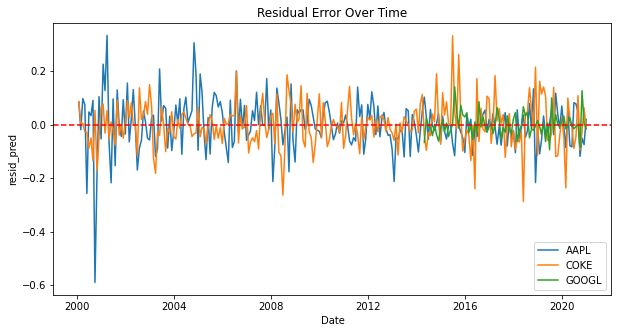

In [103]:
fig = plt.figure(figsize=(10, 5))
sns.lineplot(x='Date',y='resid_pred',data=sub,hue='TICKER')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Error Over Time')

plt.legend()
plt.show()



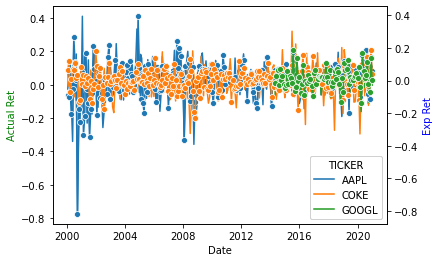

<Figure size 720x360 with 0 Axes>

In [104]:
fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 
fig = plt.figure(figsize=(10, 5))
sns.lineplot(x = 'Date', y = 'RET',data=sub,hue='TICKER', ax = ax1, color = 'blue') # plots the first set of data, and sets it to ax1. 
sns.lineplot(x = 'Date', y = 'exp_ret_excess',data=sub,hue='TICKER', marker = 'o', color = 'red', ax = ax2) # plots the second set, and sets to ax2. 

# these lines add the annotations for the plot. 
ax1.set_xlabel('Date')
ax1.set_ylabel('Actual Ret', color='g')
ax2.set_ylabel('Exp Ret', color='b')

plt.show(); # shows the plot. 

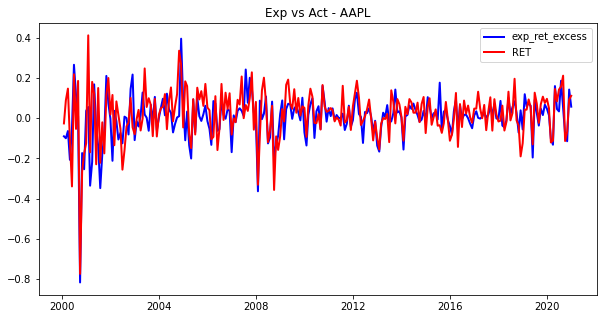

In [105]:
fig = plt.figure(figsize=(10, 5))

plt.plot( 'Date', 'exp_ret_excess', data=sub[sub['TICKER']=='AAPL'], color='blue', linewidth=2)
plt.plot( 'Date', 'RET', data=sub[sub['TICKER']=='AAPL'], color='red', linewidth=2)

plt.title('Exp vs Act - AAPL')
plt.legend()
plt.show()
 

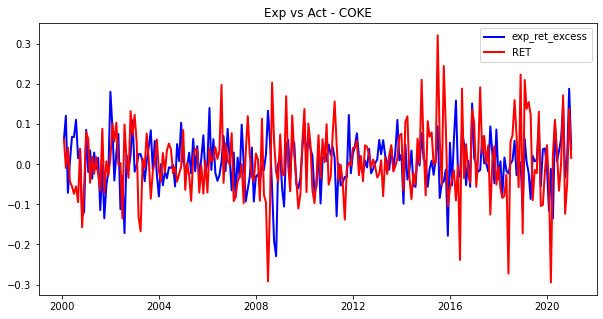

In [106]:
fig = plt.figure(figsize=(10, 5))

plt.plot( 'Date', 'exp_ret_excess', data=sub[sub['TICKER']=='COKE'], color='blue', linewidth=2)
plt.plot( 'Date', 'RET', data=sub[sub['TICKER']=='COKE'], color='red', linewidth=2)

plt.title('Exp vs Act - COKE')
plt.legend()
plt.show()

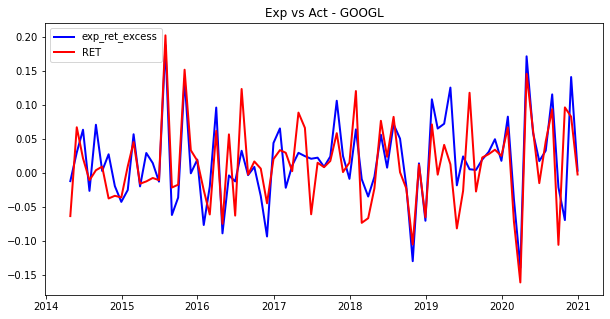

In [107]:
fig = plt.figure(figsize=(10, 5))

plt.plot( 'Date', 'exp_ret_excess', data=sub[sub['TICKER']=='GOOGL'], color='blue', linewidth=2)
plt.plot( 'Date', 'RET', data=sub[sub['TICKER']=='GOOGL'], color='red', linewidth=2)

plt.title('Exp vs Act - GOOGL')
plt.legend()
plt.show()

In [114]:
sub_aapl = sub[sub['TICKER']=='COKE']
sub_aapl.tail(24)

,Date,year,month,TICKER,RET,exp_ret_excess,pred,resid_exp,resid_pred
514,2019-01-31,2019,1,COKE,0.210321,0.062926,0.047987,0.147395,0.162334
517,2019-02-28,2019,2,COKE,0.138079,0.006292,0.024013,0.131787,0.114066
520,2019-03-31,2019,3,COKE,0.155301,-0.021219,0.014569,0.176520,0.140732
523,2019-04-30,2019,4,COKE,0.124132,-0.086411,0.017221,0.210543,0.106911
526,2019-05-31,2019,5,COKE,-0.089290,0.021094,-0.031400,-0.110384,-0.057890
529,2019-06-30,2019,6,COKE,-0.014086,0.007694,0.047969,-0.021781,-0.062056
532,2019-07-31,2019,7,COKE,-0.022080,0.010908,0.008042,-0.032989,-0.030123
535,2019-08-31,2019,8,COKE,0.131225,0.096283,-0.008271,0.034942,0.139496
538,2019-09-30,2019,9,COKE,-0.103835,-0.054500,0.015696,-0.049335,-0.119531
541,2019-10-31,2019,10,COKE,-0.101545,0.037657,0.015314,-0.139202,-0.116859


### Factor Analysis

In [67]:
factors = dataset.copy()
factors 

,year,month,TICKER,Intercept,mkt_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta,Date,RET,ewretd,sprtrn,mkt_excess,SMB,HML,RMW,CMA,RF,exp_ret_excess
0,2000,1,AAPL,7.825272,-0.220194,-0.235522,-2.566274,-0.202998,-3.595056,2000-01-31,-0.026512,0.054863,-0.053425,-0.049817,0.042313,-0.022284,-0.062559,0.046051,0.004208,-0.090457
1,2000,1,COKE,3.834545,-0.576697,-0.977171,-0.369194,-0.961569,0.050655,2000-01-31,0.062499,0.054863,-0.053425,-0.049817,0.042313,-0.022284,-0.062559,0.046051,0.004208,0.062304
2,2000,2,AAPL,-3.234763,1.633527,0.975636,-3.264296,3.499990,1.402363,2000-02-29,0.088513,0.110299,-0.021612,0.023900,0.175060,-0.077177,-0.156429,-0.013442,0.004409,-0.100177
3,2000,2,COKE,1.677548,-0.544212,0.100400,-1.771464,0.028878,1.502856,2000-02-29,-0.009046,0.110299,-0.021612,0.023900,0.175060,-0.077177,-0.156429,-0.013442,0.004409,0.120975
4,2000,3,AAPL,5.911685,0.657311,-2.193590,-0.102528,-3.501549,0.237694,2000-03-31,0.146552,0.010345,0.093186,0.045368,-0.141438,0.074089,0.113542,-0.015726,0.004610,-0.064220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,2020,11,COKE,-2.129516,1.165183,0.405588,-0.200633,-0.284737,2.041729,2020-11-30,0.137457,0.170860,0.106194,0.124006,0.058971,0.013968,-0.023112,0.007975,0.000000,0.188469
581,2020,11,GOOGL,1.293378,1.345731,-0.450508,0.230917,-0.276411,-1.145685,2020-11-30,0.082548,0.170860,0.106194,0.124006,0.058971,0.013968,-0.023112,0.007975,0.000000,0.140789
582,2020,12,AAPL,-2.377692,1.186498,-0.338630,-1.975176,0.372975,4.134430,2020-12-31,0.110699,0.076433,0.036776,0.045351,0.044864,-0.014858,-0.021044,-0.000800,0.000000,0.056807
583,2020,12,COKE,0.218357,0.108705,1.567428,0.257125,1.687689,-2.840233,2020-12-31,0.016058,0.076433,0.036776,0.045351,0.044864,-0.014858,-0.021044,-0.000800,0.000000,0.038187


#### EXP Ret and STD

Using RET as portfolio of avg returns of Google, Coke and Apple 

In [68]:
factors_returns = factors[['Date','RET','mkt_excess','SMB','HML','RMW','CMA']]
factors_mean_std = factors_returns 
factors_mean_std = factors.describe().loc[['mean','std']]
factors_mean_std

,year,month,Intercept,mkt_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta,RET,ewretd,sprtrn,mkt_excess,SMB,HML,RMW,CMA,RF,exp_ret_excess
mean,2010.984615,6.523077,0.747369,0.868740,0.204881,-0.250344,0.097406,-0.667556,0.012725,0.011106,0.003784,0.004627,0.001630,-0.000656,0.003350,0.001412,0.001210,0.004244
std,6.181731,3.448232,3.908520,0.786668,1.324464,1.510154,1.762582,2.516125,0.100474,0.055805,0.044641,0.046567,0.030682,0.032799,0.027219,0.020169,0.001434,0.085638


#### Correlations

Correlations on expected returns 

In [69]:
factors_corr_returns = factors_returns.corr()
factors_corr_returns

,RET,mkt_excess,SMB,HML,RMW,CMA
RET,1.000000,0.438836,0.135607,-0.125030,-0.171309,-0.254054
mkt_excess,0.438836,1.000000,0.333224,0.038012,-0.376506,-0.241859
SMB,0.135607,0.333224,1.000000,0.093894,-0.434047,0.009719
HML,-0.125030,0.038012,0.093894,1.000000,0.381025,0.583319
RMW,-0.171309,-0.376506,-0.434047,0.381025,1.000000,0.305220
CMA,-0.254054,-0.241859,0.009719,0.583319,0.305220,1.000000


Correlations on betas 

In [70]:
factors_betas = factors[['Date','mkt_beta','SMB_beta','HML_beta','RMW_beta','CMA_beta']]
factors_corr_betas = factors_betas.corr()
factors_corr_betas

,mkt_beta,SMB_beta,HML_beta,RMW_beta,CMA_beta
mkt_beta,1.000000,-0.069735,0.029107,-0.028588,0.081451
SMB_beta,-0.069735,1.000000,0.121174,0.120221,0.225495
HML_beta,0.029107,0.121174,1.000000,0.163749,-0.272817
RMW_beta,-0.028588,0.120221,0.163749,1.000000,-0.037348
CMA_beta,0.081451,0.225495,-0.272817,-0.037348,1.000000


### Stationary - Dickey Fuller Test

#### Returns 
each ADF corresponds to results

In [71]:
#SMB Returns
SMB = factors['SMB']
results = adfuller(SMB)
print('For SMB returns...')
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])
print('Critical Values:')
for key, value in results[4].items():
    print('\t%s: %.3f' % (key, value))
    
if results[1] > 0.05:
    print('Result is non-sationary')
else:
    print('Result is sationary')

For SMB returns...
ADF Statistic: -9.399866
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Result is sationary


In [72]:
#HML Returns
HML = factors['HML']
results = adfuller(HML)
print('For HML returns...')
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])
print('Critical Values:')
for key, value in results[4].items():
    print('\t%s: %.3f' % (key, value))
    
if results[1] > 0.05:
    print('Result is non-sationary')
else:
    print('Result is sationary')

For HML returns...
ADF Statistic: -5.083508
p-value: 0.000015
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Result is sationary


In [73]:
#HML Returns
HML = factors['HML']
results = adfuller(HML)
print('For HML returns...')
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])
print('Critical Values:')
for key, value in results[4].items():
    print('\t%s: %.3f' % (key, value))
    
if results[1] > 0.05:
    print('Result is non-sationary')
else:
    print('Result is sationary')

For HML returns...
ADF Statistic: -5.083508
p-value: 0.000015
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Result is sationary


In [74]:
#RMW Returns
RMW = factors['RMW']
results = adfuller(RMW)
print('For RMW returns...')
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])
print('Critical Values:')
for key, value in results[4].items():
    print('\t%s: %.3f' % (key, value))
    
if results[1] > 0.05:
    print('Result is non-sationary')
else:
    print('Result is sationary')


For RMW returns...
ADF Statistic: -4.619178
p-value: 0.000119
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Result is sationary


In [75]:
#CMA Returns
CMA = factors['CMA']
results = adfuller(CMA)
print('For CMA returns...')
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])
print('Critical Values:')
for key, value in results[4].items():
    print('\t%s: %.3f' % (key, value))
    
if results[1] > 0.05:
    print('Result is non-sationary')
else:
    print('Result is sationary')



For CMA returns...
ADF Statistic: -3.773642
p-value: 0.003189
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570
Result is sationary


#### Betas 
each ADF corresponds to results1

In [76]:
#SMB Beta
SMB_beta = factors['SMB_beta']
results1 = adfuller(SMB_beta)
print('For SMB beta...')
print('ADF Statistic: %f' % results1[0])
print('p-value: %f' % results1[1])
print('Critical Values:')
for key, value in results1[4].items():
    print('\t%s: %.3f' % (key, value))

if results1[1] > 0.05:
    print('Result is non-sationary')
else:
    print('Result is sationary')

For SMB beta...
ADF Statistic: -4.785621
p-value: 0.000058
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Result is sationary


In [77]:
#HML Beta
HML_beta = factors['HML_beta']
results1 = adfuller(HML_beta)
print('For HML beta...')
print('ADF Statistic: %f' % results1[0])
print('p-value: %f' % results1[1])
print('Critical Values:')
for key, value in results1[4].items():
    print('\t%s: %.3f' % (key, value))

if results1[1] > 0.05:
    print('Result is non-sationary')
else:
    print('Result is sationary')

For HML beta...
ADF Statistic: -8.305533
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Result is sationary


In [78]:
#RMW Beta
RMW_beta = factors['RMW_beta']
results1 = adfuller(RMW_beta)
print('For RMW beta...')
print('ADF Statistic: %f' % results1[0])
print('p-value: %f' % results1[1])
print('Critical Values:')
for key, value in results1[4].items():
    print('\t%s: %.3f' % (key, value))

if results1[1] > 0.05:
    print('Result is non-sationary')
else:
    print('Result is sationary')

For RMW beta...
ADF Statistic: -4.709437
p-value: 0.000081
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Result is sationary


In [79]:
#CMA Beta
CMA_beta = factors['CMA_beta']
results1 = adfuller(CMA_beta)
print('For CMA beta...')
print('ADF Statistic: %f' % results1[0])
print('p-value: %f' % results1[1])
print('Critical Values:')
for key, value in results1[4].items():
    print('\t%s: %.3f' % (key, value))

if results1[1] > 0.05:
    print('Result is non-sationary')
else:
    print('Result is sationary')

For CMA beta...
ADF Statistic: -5.228934
p-value: 0.000008
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Result is sationary


In [80]:
#mkt Beta
mkt_beta = factors['mkt_beta']
results1 = adfuller(mkt_beta)
print('For mkt beta...')
print('ADF Statistic: %f' % results1[0])
print('p-value: %f' % results1[1])
print('Critical Values:')
for key, value in results1[4].items():
    print('\t%s: %.3f' % (key, value))

if results1[1] > 0.05:
    print('Result is non-sationary')
else:
    print('Result is sationary')

For mkt beta...
ADF Statistic: -4.573361
p-value: 0.000145
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
Result is sationary
